In [1]:
from graphframes import *
from pyspark import SparkContext

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [3]:
nodes = spark.read.csv("data/airports.csv", header=False)

cleaned_nodes = (nodes.select("_c1", "_c3", "_c4", "_c6", "_c7")
                     .filter("_c3 = 'United States'")
                     .withColumnRenamed("_c1", "name")
                     .withColumnRenamed("_c4", "id")
                     .withColumnRenamed("_c6", "latitude")
                     .withColumnRenamed("_c7", "longitude")
                     .drop("_c3"))

cleaned_nodes = cleaned_nodes[cleaned_nodes["id"] != "\\N"]

In [4]:
relationships = spark.read.csv("data/188591317_T_ONTIME.csv", header=True)

cleaned_relationships = (relationships
                         .select("ORIGIN", "DEST", "FL_DATE", "DEP_DELAY",
                                 "ARR_DELAY", "DISTANCE", "TAIL_NUM", "FL_NUM",
                                  "CRS_DEP_TIME", "CRS_ARR_TIME",
                                  "UNIQUE_CARRIER")
                         .withColumnRenamed("ORIGIN", "src")
                         .withColumnRenamed("DEST", "dst")
                         .withColumnRenamed("DEP_DELAY", "deptDelay")
                         .withColumnRenamed("ARR_DELAY", "arrDelay")
                         .withColumnRenamed("TAIL_NUM", "tailNumber")
                         .withColumnRenamed("FL_NUM", "flightNumber")
                         .withColumnRenamed("FL_DATE", "date")
                         .withColumnRenamed("CRS_DEP_TIME", "time")
                         .withColumnRenamed("CRS_ARR_TIME", "arrivalTime")
                         .withColumnRenamed("DISTANCE", "distance")
                         .withColumnRenamed("UNIQUE_CARRIER", "airline")
                         .withColumn("deptDelay",
                              F.col("deptDelay").cast(FloatType()))
                         .withColumn("arrDelay",
                              F.col("arrDelay").cast(FloatType()))
                         .withColumn("time", F.col("time").cast(IntegerType()))
                         .withColumn("arrivalTime",
                              F.col("arrivalTime").cast(IntegerType()))
                         )


In [5]:
g = GraphFrame(cleaned_nodes, cleaned_relationships)

In [6]:
airlines_reference = (spark.read.csv("data/airlines.csv")
                      .select("_c1", "_c3")
                      .withColumnRenamed("_c1", "name")
                      .withColumnRenamed("_c3", "code"))
airlines_reference = airlines_reference[airlines_reference["code"] != "null"]

In [7]:
g.vertices.count()

1333

In [8]:
g.edges.count()

616529

In [9]:
airports_degree = g.outDegrees.withColumnRenamed("id", "oId")

full_airports_degree = (airports_degree
                        .join(g.vertices, airports_degree.oId == g.vertices.id)
                        .sort("outDegree", ascending=False)
                        .select("id", "name", "outDegree"))
full_airports_degree.show(n=10, truncate=False)

+---+------------------------------------------------+---------+
|id |name                                            |outDegree|
+---+------------------------------------------------+---------+
|ATL|Hartsfield Jackson Atlanta International Airport|33837    |
|ORD|Chicago O'Hare International Airport            |28338    |
|DFW|Dallas Fort Worth International Airport         |23765    |
|CLT|Charlotte Douglas International Airport         |20251    |
|DEN|Denver International Airport                    |19836    |
|LAX|Los Angeles International Airport               |19059    |
|PHX|Phoenix Sky Harbor International Airport        |15103    |
|SFO|San Francisco International Airport             |14934    |
|LGA|La Guardia Airport                              |14709    |
|IAH|George Bush Intercontinental Houston Airport    |14407    |
+---+------------------------------------------------+---------+
only showing top 10 rows



In [10]:
from matplotlib import pyplot as plt

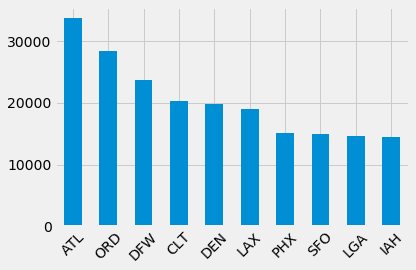

In [11]:
plt.style.use('fivethirtyeight')
ax = (full_airports_degree
      .toPandas()
      .head(10)
      .plot(kind='bar', x='id', y='outDegree', legend=None))
ax.xaxis.set_label_text("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
delayed_flights = (g.edges
                   .filter("src = 'ORD' and deptDelay > 0")
                   .groupBy("dst")
                   .agg(F.avg("deptDelay"), F.count("deptDelay"))
                   .withColumn("averageDelay",
                               F.round(F.col("avg(deptDelay)"), 2))
                   .withColumn("numberOfDelays",
                               F.col("count(deptDelay)")))
(delayed_flights
 .join(g.vertices, delayed_flights.dst == g.vertices.id)
 .sort(F.desc("averageDelay"))
 .select("dst", "name", "averageDelay", "numberOfDelays")
 .show(n=10, truncate=False))

+---+-------------------------------------------+------------+--------------+
|dst|name                                       |averageDelay|numberOfDelays|
+---+-------------------------------------------+------------+--------------+
|CKB|North Central West Virginia Airport        |145.08      |12            |
|OGG|Kahului Airport                            |119.67      |9             |
|MQT|Sawyer International Airport               |114.75      |12            |
|MOB|Mobile Regional Airport                    |102.2       |10            |
|TTN|Trenton Mercer Airport                     |101.18      |17            |
|AVL|Asheville Regional Airport                 |98.5        |28            |
|ISP|Long Island Mac Arthur Airport             |94.08       |13            |
|ANC|Ted Stevens Anchorage International Airport|83.74       |23            |
|BTV|Burlington International Airport           |83.2        |25            |
|CMX|Houghton County Memorial Airport           |79.18       |17

In [13]:
from_expr = 'id = "ORD"'
to_expr = 'id = "CKB"'
ord_to_ckb = g.bfs(from_expr, to_expr)
ord_to_ckb = ord_to_ckb.select(
  F.col("e0.date"),
  F.col("e0.time"),
  F.col("e0.flightNumber"),
  F.col("e0.deptDelay"))

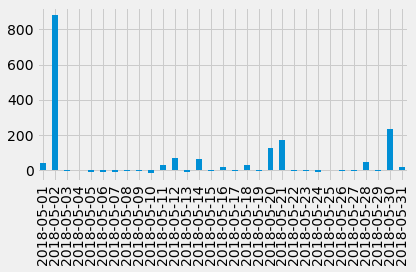

In [14]:
ax = (ord_to_ckb
      .sort("date")
      .toPandas()
      .plot(kind='bar', x='date', y='deptDelay', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [15]:
motifs = (g.find("(a)-[ab]->(b); (b)-[bc]->(c)")
          .filter("""(b.id = 'SFO') and
                  (ab.date = '2018-05-11' and bc.date = '2018-05-11') and
                  (ab.arrDelay > 30 or bc.deptDelay > 30) and
                  (ab.flightNumber = bc.flightNumber) and
                  (ab.airline = bc.airline) and
                  (ab.time < bc.time)"""))

result = (motifs.withColumn("delta", motifs.bc.deptDelay - motifs.ab.arrDelay)
          .select("ab", "bc", "delta")
          .sort("delta", ascending=False))

result.select(
    F.col("ab.src").alias("a1"),
    F.col("ab.time").alias("a1DeptTime"),
    F.col("ab.arrDelay"),
    F.col("ab.dst").alias("a2"),
    F.col("bc.time").alias("a2DeptTime"),
    F.col("bc.deptDelay"),
    F.col("bc.dst").alias("a3"),
    F.col("ab.airline"),
    F.col("ab.flightNumber"),
    F.col("delta")
).show()

+---+----------+--------+---+----------+---------+---+-------+------------+-----+
| a1|a1DeptTime|arrDelay| a2|a2DeptTime|deptDelay| a3|airline|flightNumber|delta|
+---+----------+--------+---+----------+---------+---+-------+------------+-----+
|PDX|      1130|   -18.0|SFO|      1350|    178.0|BUR|     WN|        1454|196.0|
|ACV|      1755|    -9.0|SFO|      2235|     64.0|RDM|     OO|        5700| 73.0|
|BWI|       700|    -3.0|SFO|      1125|     49.0|IAD|     UA|         753| 52.0|
|ATL|       740|    40.0|SFO|      1110|     77.0|SAN|     UA|        1900| 37.0|
|BUR|      1405|    25.0|SFO|      1600|     39.0|PDX|     WN|         157| 14.0|
|DTW|       835|    34.0|SFO|      1135|     44.0|DTW|     DL|         745| 10.0|
|DEN|      1830|    25.0|SFO|      2045|     33.0|BUR|     WN|        1783|  8.0|
|PDX|      1855|   119.0|SFO|      2120|    117.0|DEN|     WN|        5789| -2.0|
|BUR|      2025|    31.0|SFO|      2230|     11.0|PHX|     WN|        1585|-20.0|
+---+----------+

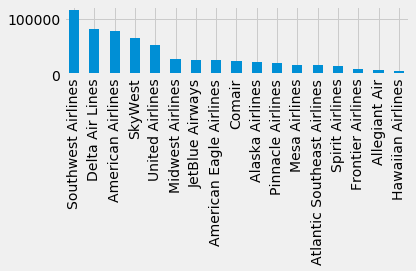

In [16]:
airlines = (g.edges
             .groupBy("airline")
             .agg(F.count("airline").alias("flights"))
             .sort("flights", ascending=False))

full_name_airlines = (airlines_reference
                      .join(airlines, airlines.airline
                            == airlines_reference.code)
                      .select("code", "name", "flights"))

ax = (full_name_airlines.toPandas()
      .plot(kind='bar', x='name', y='flights', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [17]:
def find_scc_components(g, airline):
    # Create a subgraph containing only flights on the provided airline 
    airline_relationships = g.edges[g.edges.airline == airline] 
    airline_graph = GraphFrame(g.vertices, airline_relationships)
        
    # Calculate the Strongly Connected Components
    scc = airline_graph.stronglyConnectedComponents(maxIter=10)
    
    # Find the size of the biggest component and return that
    return (scc
            .groupBy("component")
            .agg(F.count("id").alias("size"))
            .sort("size", ascending=False)
            .take(1)[0]["size"])

In [18]:
# Calculate the largest strongly connected component for each airline
airline_scc = [(airline, find_scc_components(g, airline))
               for airline in airlines.toPandas()["airline"].tolist()]
airline_scc_df = spark.createDataFrame(airline_scc, ['id', 'sccCount'])
    
# Join the SCC DataFrame with the airlines DataFrame so that we can show 
# the number of flights an airline has alongside the number of
# airports reachable in its biggest component
airline_reach = (airline_scc_df
     .join(full_name_airlines, full_name_airlines.code == airline_scc_df.id)
     .select("code", "name", "flights", "sccCount")
     .sort("sccCount", ascending=False))

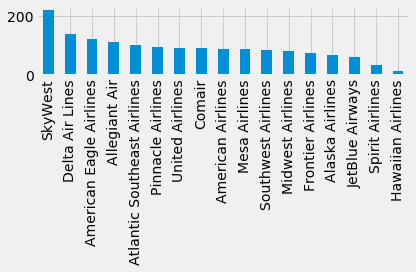

In [19]:
ax = (airline_reach.toPandas()
      .plot(kind='bar', x='name', y='sccCount', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [20]:
airline_relationships = g.edges.filter("airline = 'DL'")
airline_graph = GraphFrame(g.vertices, airline_relationships)
clusters = airline_graph.labelPropagation(maxIter=10)

(clusters
 .sort("label")
 .groupby("label")
 .agg(F.collect_list("id").alias("airports"),
      F.count("id").alias("count"))
 .sort("count", ascending=False)
 .show(truncate=70, n=10))

+-------------+----------------------------------------------------------------------+-----+
|        label|                                                              airports|count|
+-------------+----------------------------------------------------------------------+-----+
|1606317768706|[IND, ORF, ATW, RIC, TRI, XNA, ECP, AVL, JAX, SYR, BHM, GSO, MEM, C...|   89|
|1219770712067|[GEG, SLC, DTW, LAS, SEA, BOS, MSN, SNA, JFK, TVC, LIH, JAC, FLL, M...|   53|
|  17179869187|                                                                 [RHV]|    1|
|  25769803777|                                                                 [CWT]|    1|
|  25769803776|                                                                 [CDW]|    1|
|   8589934593|                                                                 [AVX]|    1|
|  25769803778|                                                                 [DRT]|    1|
|  25769803779|                                                       

In [21]:
all_flights = g.degrees.withColumnRenamed("id", "aId")

In [22]:
result.show()

+--------------------+--------------------+-----+
|                  ab|                  bc|delta|
+--------------------+--------------------+-----+
|[PDX, SFO, 2018-0...|[SFO, BUR, 2018-0...|196.0|
|[ACV, SFO, 2018-0...|[SFO, RDM, 2018-0...| 73.0|
|[BWI, SFO, 2018-0...|[SFO, IAD, 2018-0...| 52.0|
|[ATL, SFO, 2018-0...|[SFO, SAN, 2018-0...| 37.0|
|[BUR, SFO, 2018-0...|[SFO, PDX, 2018-0...| 14.0|
|[DTW, SFO, 2018-0...|[SFO, DTW, 2018-0...| 10.0|
|[DEN, SFO, 2018-0...|[SFO, BUR, 2018-0...|  8.0|
|[PDX, SFO, 2018-0...|[SFO, DEN, 2018-0...| -2.0|
|[BUR, SFO, 2018-0...|[SFO, PHX, 2018-0...|-20.0|
+--------------------+--------------------+-----+



In [23]:
clusters.filter("label=1606317768706").id

Column<b'id'>

In [24]:
cluster = clusters.filter("label=1606317768706")
(cluster
 .join(all_flights, all_flights.aId == cluster.id)
 .sort("degree", ascending=False)
 .select("id", "name", "degree")
 .show(truncate=False))

+---+------------------------------------------------------------+------+
|id |name                                                        |degree|
+---+------------------------------------------------------------+------+
|DFW|Dallas Fort Worth International Airport                     |47514 |
|CLT|Charlotte Douglas International Airport                     |40495 |
|IAH|George Bush Intercontinental Houston Airport                |28814 |
|EWR|Newark Liberty International Airport                        |25131 |
|PHL|Philadelphia International Airport                          |20804 |
|BWI|Baltimore/Washington International Thurgood Marshall Airport|18989 |
|MDW|Chicago Midway International Airport                        |15178 |
|BNA|Nashville International Airport                             |12455 |
|DAL|Dallas Love Field                                           |12084 |
|IAD|Washington Dulles International Airport                     |11566 |
|STL|Lambert St Louis International Ai

In [25]:
cluster = clusters.filter("label=1219770712067")
(cluster
 .join(all_flights, all_flights.aId == cluster.id)
 .sort("degree", ascending=False)
 .select("id", "name", "degree")
 .show(truncate=False))

+---+----------------------------------------------------------+------+
|id |name                                                      |degree|
+---+----------------------------------------------------------+------+
|ATL|Hartsfield Jackson Atlanta International Airport          |67672 |
|ORD|Chicago O'Hare International Airport                      |56681 |
|DEN|Denver International Airport                              |39671 |
|LAX|Los Angeles International Airport                         |38116 |
|PHX|Phoenix Sky Harbor International Airport                  |30206 |
|SFO|San Francisco International Airport                       |29865 |
|LGA|La Guardia Airport                                        |29416 |
|LAS|McCarran International Airport                            |27801 |
|DTW|Detroit Metropolitan Wayne County Airport                 |27477 |
|MSP|Minneapolis-St Paul International/Wold-Chamberlain Airport|27163 |
|BOS|General Edward Lawrence Logan International Airport       |